In [1]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import tqdm
from transformers import get_linear_schedule_with_warmup

from UNet import UNet
from SimpleUNet import SimpleUNet

### Hyper-parameters

In [2]:
# training
batch_size = 128
eval_batch_size = 256
learning_rate = 2e-4
num_epochs = 10
num_warmup_stesp = 100

# diffusion model
diffusion_steps = 1000
beta_large = 0.02
beta_small = 1e-4

### Setup

In [3]:
# train_loader = torch.utils.data.DataLoader(
#       torchvision.datasets.MNIST('/tmp/', train=True, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                  torchvision.transforms.Pad(2)
#                                # torchvision.transforms.Resize(32),
#                              ])),
#       batch_size=batch_size, shuffle=True)

# test_loader = torch.utils.data.DataLoader(
#      torchvision.datasets.MNIST('/tmp/', train=False, download=True,
#                              transform=torchvision.transforms.Compose([
#                                torchvision.transforms.ToTensor(),
#                                 torchvision.transforms.Pad(2)
#                                # torchvision.transforms.Resize(32),
#                              ])),
#       batch_size=eval_batch_size, shuffle=True)

In [4]:
class DiffSet(Dataset):
    def __init__(self, train, dataset="MNIST"):
        transform = transforms.Compose([transforms.ToTensor()])

        datasets = {
            "MNIST": MNIST,
            "Fashion": FashionMNIST,
            "CIFAR": CIFAR10,
        }

        train_dataset = datasets[dataset](
            "./data", download=True, train=train, transform=transform
        )

        self.dataset_len = len(train_dataset.data)

        if dataset == "MNIST" or dataset == "Fashion":
            pad = transforms.Pad(2)
            data = pad(train_dataset.data)
            data = data.unsqueeze(3)
            self.depth = 1
            self.size = 32
        elif dataset == "CIFAR":
            data = torch.Tensor(train_dataset.data)
            self.depth = 3
            self.size = 32
        self.input_seq = ((data / 255.0) * 2.0) - 1.0
        self.input_seq = self.input_seq.moveaxis(3, 1)

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, item):
        return self.input_seq[item]

In [5]:
train_dataset = DiffSet(True, "MNIST")
val_dataset = DiffSet(False, "MNIST")

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

In [6]:
# model
# model = UNet(
#         input_channels=1,
#         input_height=32,
#         ch=64,
#         ch_mult=(1, 2, 2, 2),
#         num_res_blocks=1,
#         attn_resolutions=(16,),
#         resamp_with_conv=True,
#         dropout=0.,
#         )

model = SimpleUNet(img_depth=1)

### Tests Model and DataLoader

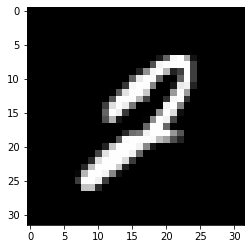

In [7]:
for batch in train_loader:
    break

img = batch[0][0].view(32,32)
fig = plt.figure
plt.imshow(img, cmap='gray')
plt.show()

In [8]:
x_ = torch.randn(1, 1, 32, 32)
t = torch.zeros(1)
output = model(x_, t)
output.shape

torch.Size([1, 1, 32, 32])

In [9]:
# number of parameters
sum(p.numel() for p in model.parameters()) // 1e6

12.0

### Training

In [10]:
# def add_noise(imgs):
#     z_noise = torch.randn_like(imgs)
#     ts = torch.randint(0, diffusion_steps, (imgs.shape[0],), device=imgs.device)
#     a_sampled = alpha_bars[ts].view(-1, 1, 1, 1)
#     noised_imgs = torch.sqrt(a_sampled) * imgs + torch.sqrt(1 - a_sampled) * z_noise
#     return noised_imgs, ts, z_noise

In [11]:
# coefficietns
betas = torch.Tensor([beta_small + (t / diffusion_steps) * (beta_large - beta_small) for t in range(diffusion_steps)])
alphas = 1 - betas
alpha_bars = torch.cumprod(alphas, 0)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_stesp, num_training_steps=len(train_loader)*num_epochs)

In [13]:
# send to device
device = torch.device("cuda")
model = model.to(device)
betas = betas.to(device)
alphas = alphas.to(device)
alpha_bars = alpha_bars.to(device)

In [14]:
def beta(t):
    return beta_small + (t / diffusion_steps) * (
        beta_large - beta_small
    )

def alpha(t):
    return 1 - beta(t)

def alpha_bar(t):
    return math.prod([alpha(j) for j in range(t)])

In [15]:
def add_noise(imgs):
    
    ts = torch.randint(0, diffusion_steps, [imgs.shape[0]], device=imgs.device)
    noise_imgs = []
    epsilons = torch.randn(imgs.shape, device=imgs.device)
    for i in range(len(ts)):
        a_hat = alpha_bar(ts[i])
        noise_imgs.append(
            (math.sqrt(a_hat) * imgs[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
        )
    noise_imgs = torch.stack(noise_imgs, dim=0)
    return noise_imgs, ts, epsilons

In [16]:
for epoch in range(num_epochs):
    
    model.train()
    pbar = tqdm.auto.tqdm(train_loader)
    moving_loss = 0.0
    for batch in pbar:
        # imgs, labels = batch
        imgs = batch
        imgs = imgs.to(device)
        # imgs = imgs * 2 - 1
        
        noised_imgs, ts, z_noise = add_noise(imgs)
        
        e_hat = model(noised_imgs, ts)
        
        loss = nn.functional.mse_loss(
            e_hat.reshape(imgs.shape[0], -1), z_noise.reshape(imgs.shape[0], -1)
        )
        
        moving_loss = moving_loss * 0.9 + 0.1 * loss.item()
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        pbar.set_postfix({'loss': moving_loss})
        
    with torch.no_grad():
        model.eval()
        with torch.random.fork_rng():
            torch.random.manual_seed(123)
            loss = 0
            for batch in tqdm.auto.tqdm(test_loader):
                # imgs, labels = batch
                imgs = batch
                imgs = imgs.to(device)
                # imgs = imgs * 2 - 1

                noised_imgs, ts, z_noise = add_noise(imgs)

                e_hat = model(noised_imgs, ts)

                loss += nn.functional.mse_loss(
                    e_hat.reshape(imgs.shape[0], -1), z_noise.reshape(imgs.shape[0], -1)
                )

            loss /= len(test_loader)
            print(f"Epoch {epoch} Validation loss: {loss}")

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
batch[0].shape

In [ ]:
"""
Corresponds to Algorithm 1 from (Ho et al., 2020).
"""
ts = torch.randint(0, self.t_range, [batch.shape[0]], device=self.device)
noise_imgs = []
epsilons = torch.randn(batch.shape, device=self.device)
for i in range(len(ts)):
    a_hat = self.alpha_bar(ts[i])
    noise_imgs.append(
        (math.sqrt(a_hat) * batch[i]) + (math.sqrt(1 - a_hat) * epsilons[i])
    )
noise_imgs = torch.stack(noise_imgs, dim=0)
e_hat = self.forward(noise_imgs, ts.unsqueeze(-1).type(torch.float))
loss = nn.functional.mse_loss(
    e_hat.reshape(-1, self.in_size), epsilons.reshape(-1, self.in_size)
)

In [ ]:
# Process samples and save as gif
gen_samples = (gen_samples * 255).type(torch.uint8)
gen_samples = gen_samples.reshape(-1, gif_shape[0], gif_shape[1], train_dataset.size, train_dataset.size, train_dataset.depth)

def stack_samples(gen_samples, stack_dim):
    gen_samples = list(torch.split(gen_samples, 1, dim=1))
    for i in range(len(gen_samples)):
        gen_samples[i] = gen_samples[i].squeeze(1)
    return torch.cat(gen_samples, dim=stack_dim)

gen_samples = stack_samples(gen_samples, 2)
gen_samples = stack_samples(gen_samples, 2)

imageio.mimsave(
    f"{trainer.logger.log_dir}/pred.gif",
    list(gen_samples),
    fps=5,
)